In [3]:
%cd ..


d:\~Perso\Etudes\DAC\NeuralNetworksDIY


In [4]:
import numpy as np
import pandas as pd
from src.convolution import *
from src.linear import *
from src.loss import *
from src.activation import *
from src.encapsulation import *
from utils.mltools import *
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler


def load_usps(fn):
    with open(fn, "r") as f:
        f.readline()
        data = [[float(X) for X in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)
    return tmp[:, 1:], tmp[:, 0].astype(int)


def get_usps(l, X, y):
    if type(l) != list:
        resx = X[y == l, :]
        resy = y[y == l]
        return resx, resy
    tmp = list(zip(*[get_usps(i, X, y) for i in l]))
    tmpx, tmpy = np.vstack(tmp[0]), np.hstack(tmp[1])
    return tmpx, tmpy


def load_one_class(number):
    X_train, y_train = get_usps(number, X_train, y_train)
    X_test, y_test = get_usps(number, X_test, y_test)
    y_train = np.where(y_train == number, -1, 1).reshape(-1, 1)
    y_test = np.where(y_test == number, -1, 1).reshape(-1, 1)
    return X_train, y_train, X_test, y_test


def load_two_classes(neg, pos):
    X_train, y_train = get_usps([neg, pos], X_train, y_train)
    X_test, y_test = get_usps([neg, pos], X_test, y_test)
    y_train = np.where(y_train == neg, -1, 1).reshape(-1, 1)
    y_test = np.where(y_test == neg, -1, 1).reshape(-1, 1)
    return X_train, y_train, X_test, y_test


def normalize_batch_image(X):
    mn = np.min(X)
    mx = np.max(X)
    X_norm = (X - mn) * (1.0 / (mx - mn))
    return X_norm

X_train, y_train = load_usps("data/USPS_train.txt")
X_test, y_test = load_usps("data/USPS_test.txt")
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()

X_train = normalize_batch_image(X_train)
X_test = normalize_batch_image(X_test)

d:\~Perso\Etudes\DAC\NeuralNetworksDIY\src\encapsulation.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
def plot(output_path=None):
    sns.set_theme(context="talk", style="whitegrid", palette="deep")

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,5))

    loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
    sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax[0])

    score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
    sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax[1])

    sns.set_theme(context="notebook")
    ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(1), optimizer.network.forward(optimizer.X_test).argmax(1), ax=ax[2])
    ax[2].grid(False)
    sns.set_theme(context="talk")

    plt.tight_layout()

    if output_path:
        fig.savefig(output_path, dpi=100, bbox_inches="tight")


## Chiffres

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/4884 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/610 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/305 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/76 [00:00<?, ?it/s]

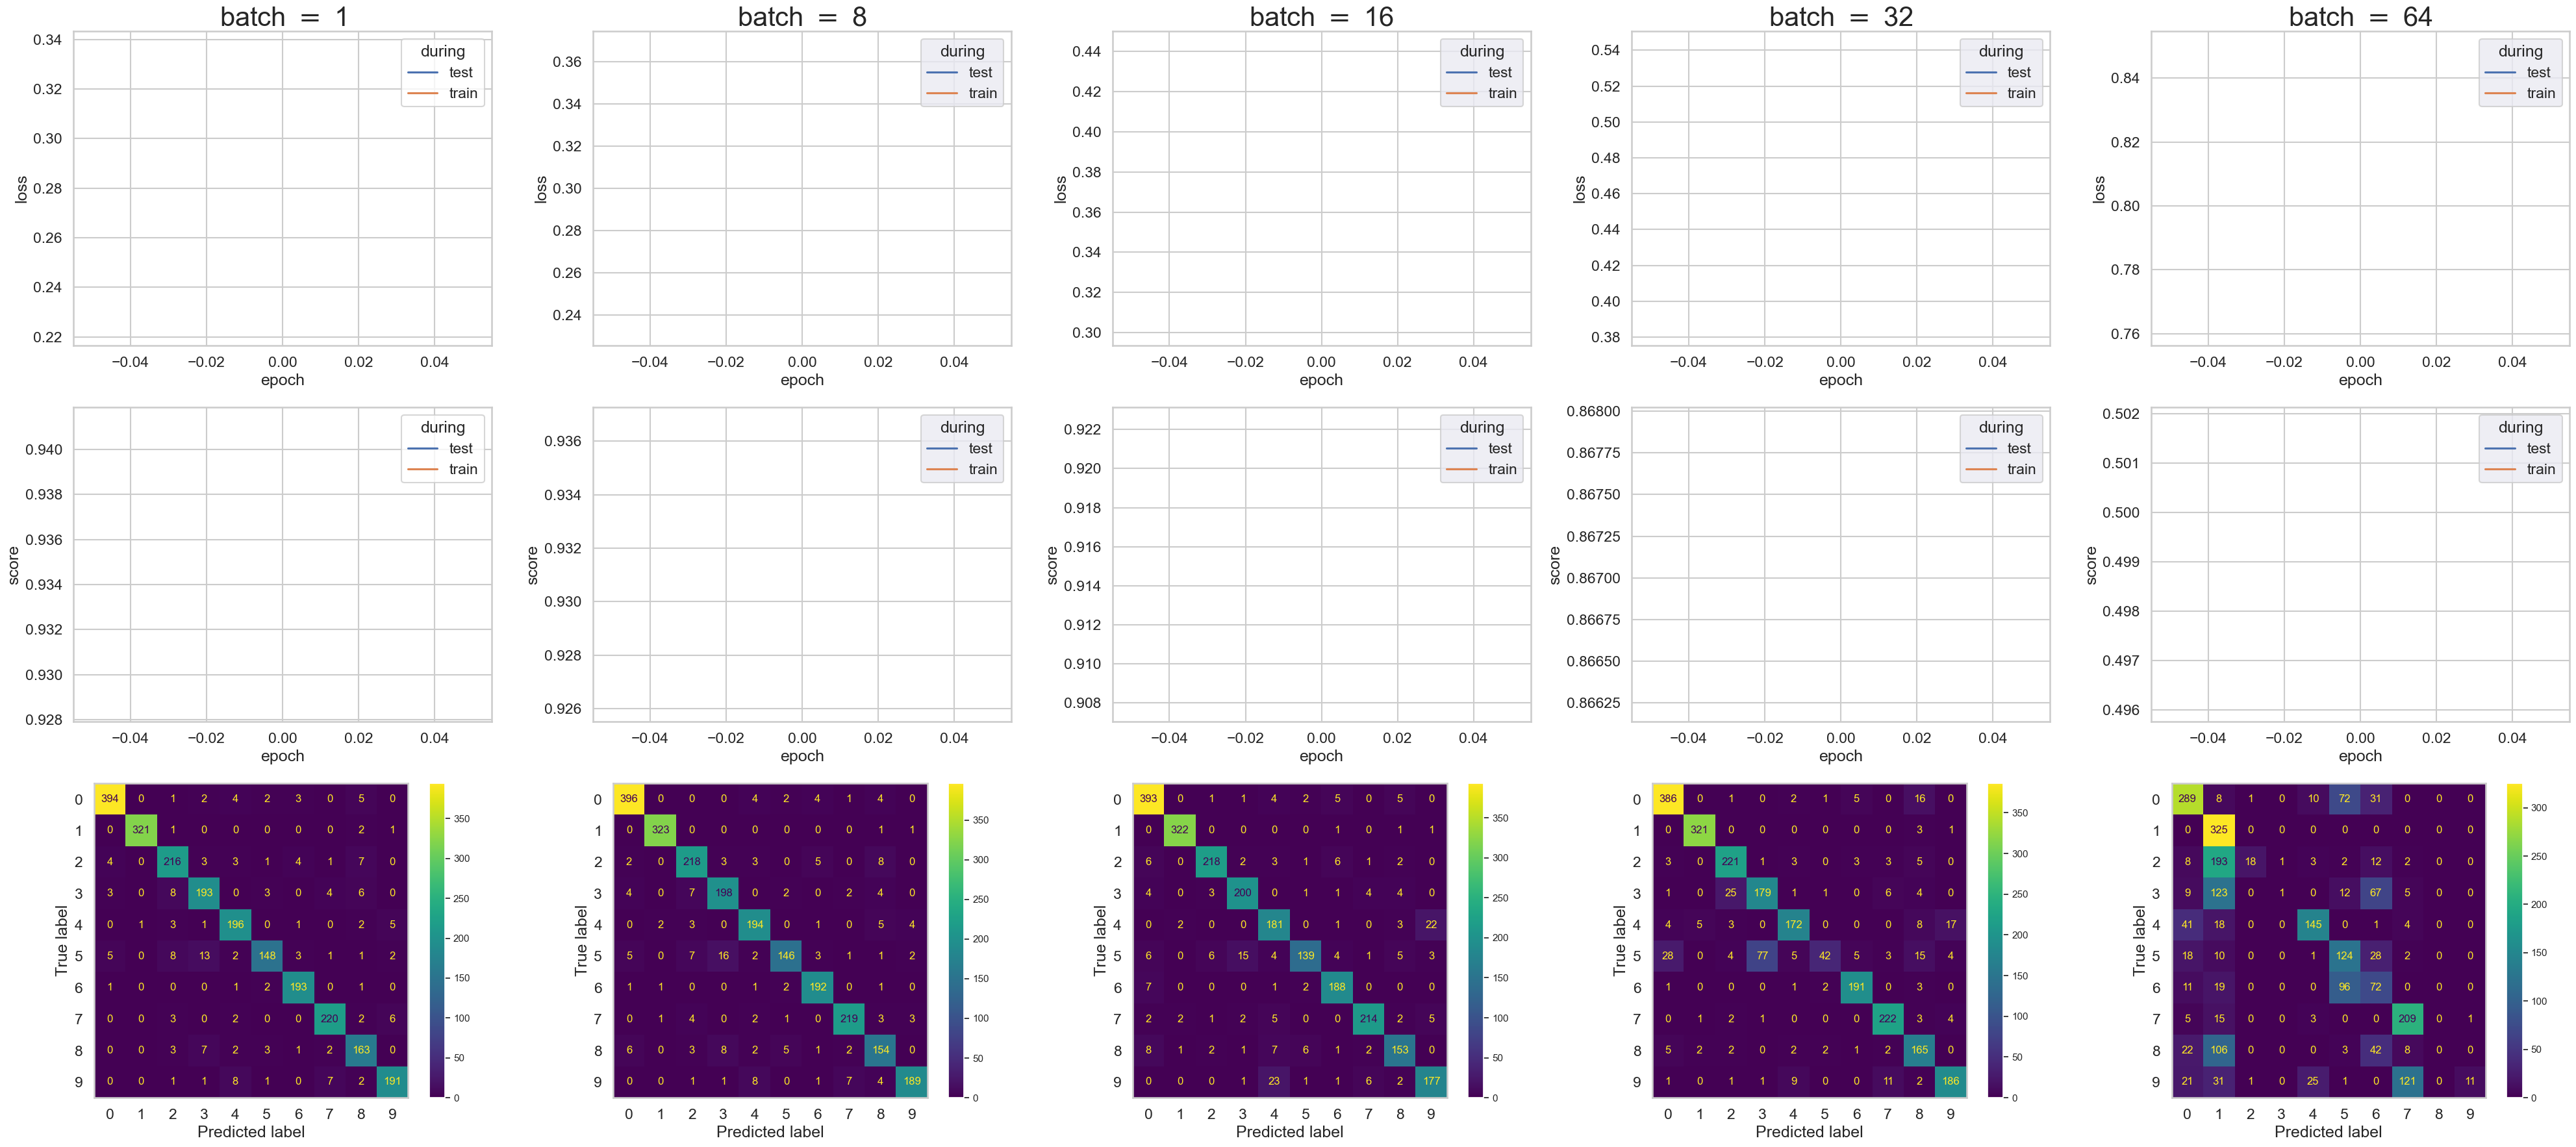

In [18]:
epochs = 25

sns.set_theme(context= "talk", style='whitegrid', palette="deep")

fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(40, 18))
fig.set_tight_layout(True)

for i, batch_size in enumerate([1, 8, 16, 32, 64, 128]):
    ax_col = ax[:, i]
    ax_col[0].set_title(f"batch $=$ {batch_size}", size=30)

    net = Sequential(
        Conv1D(3, 1, 32, 1),
        MaxPool1D(2, 2),
        Flatten(),
        Linear(4064, 100),
        ReLU(),
        Linear(100, 10),
    )

    optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=0.001)
    result_df = optimizer.SGD_eval(X_train[:, :, np.newaxis], y_train, batch_size, epochs, test_size=0.33, return_dataframe=True)

    loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
    sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax_col[0])

    score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
    sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax_col[1])
    
    sns.set_theme(context="notebook")
    ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(1), optimizer.network.forward(optimizer.X_test).argmax(1), ax=ax_col[2])
    ax_col[2].grid(False)
    sns.set_theme(context= "talk")
    
fig.savefig("./reports/src/conv/conv_batch.pdf", dpi=100, bbox_inches="tight")

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

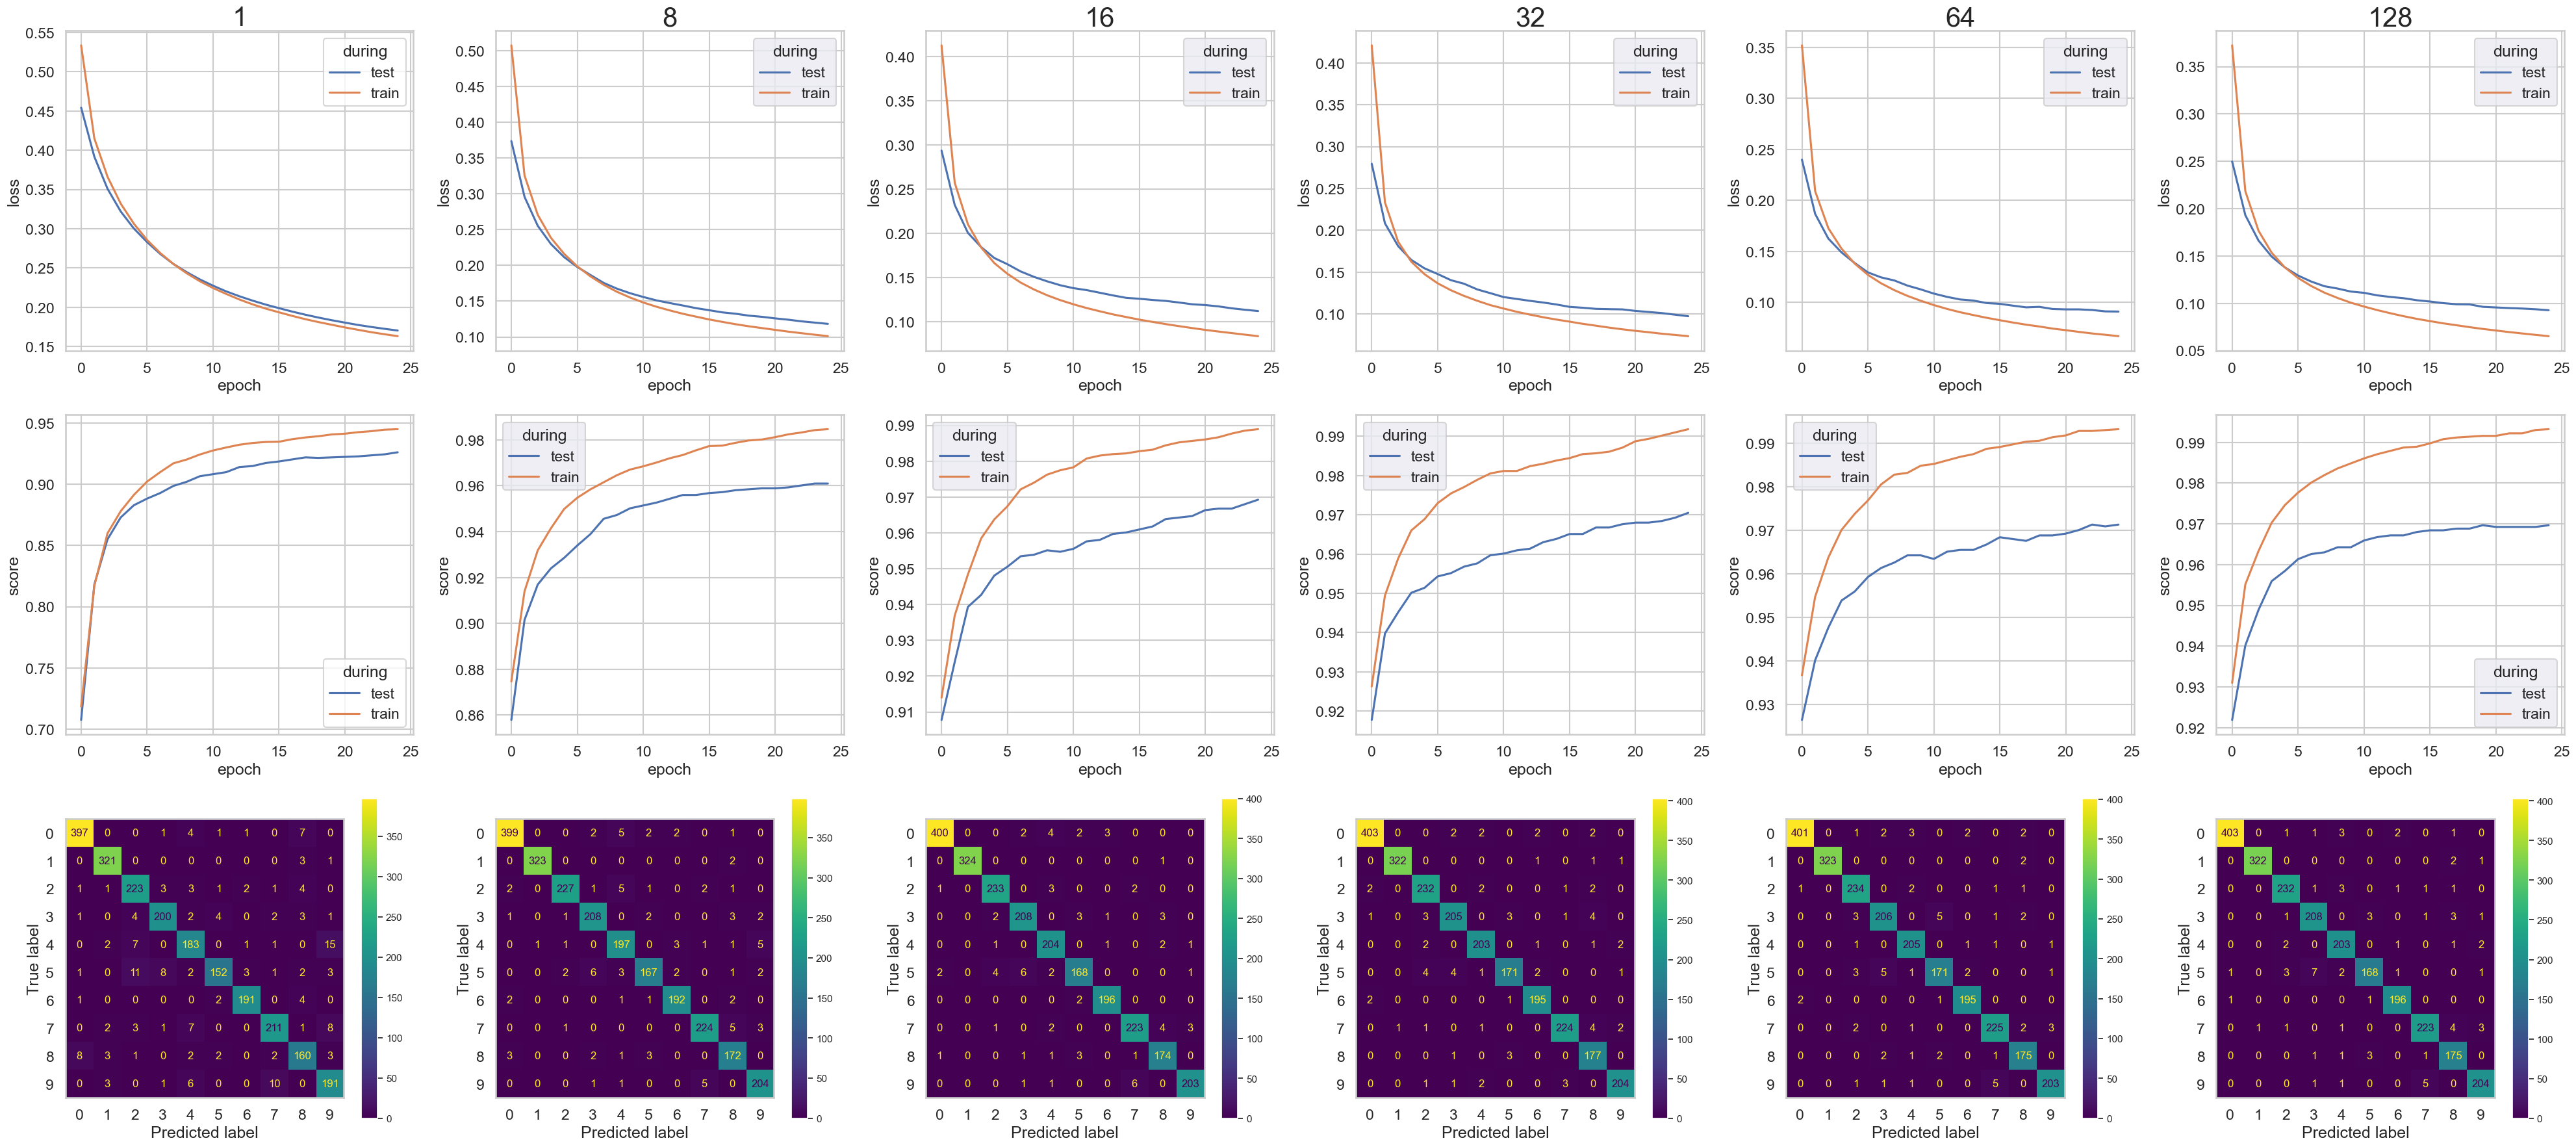

In [8]:
sns.set_theme(context= "talk", style='whitegrid', palette="deep")

fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(40, 18))
fig.set_tight_layout(True)

for i, feature_maps in enumerate([1, 8, 16, 32, 64, 128]):
    ax_col = ax[:, i]
    ax_col[0].set_title(feature_maps, size=30)

    net = Sequential(
        Conv1D(3, 1, feature_maps, 1),
        MaxPool1D(2, 2),
        Flatten(),
        Linear(127 * feature_maps, 100),
        ReLU(),
        Linear(100, 10),
    )    

    optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=0.001)
    result_df = optimizer.SGD_eval(X_train[:, :, np.newaxis], y_train, 32, 25, test_size=0.33, return_dataframe=True)

    loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
    sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax_col[0])

    score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
    sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax_col[1])
    
    sns.set_theme(context="notebook")
    ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(1), optimizer.network.forward(optimizer.X_test).argmax(1), ax=ax_col[2])
    ax_col[2].grid(False)
    sns.set_theme(context= "talk")
    
# fig.savefig("./reports/src/conv/conv_feature_maps.pdf", dpi=100, bbox_inches="tight")

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

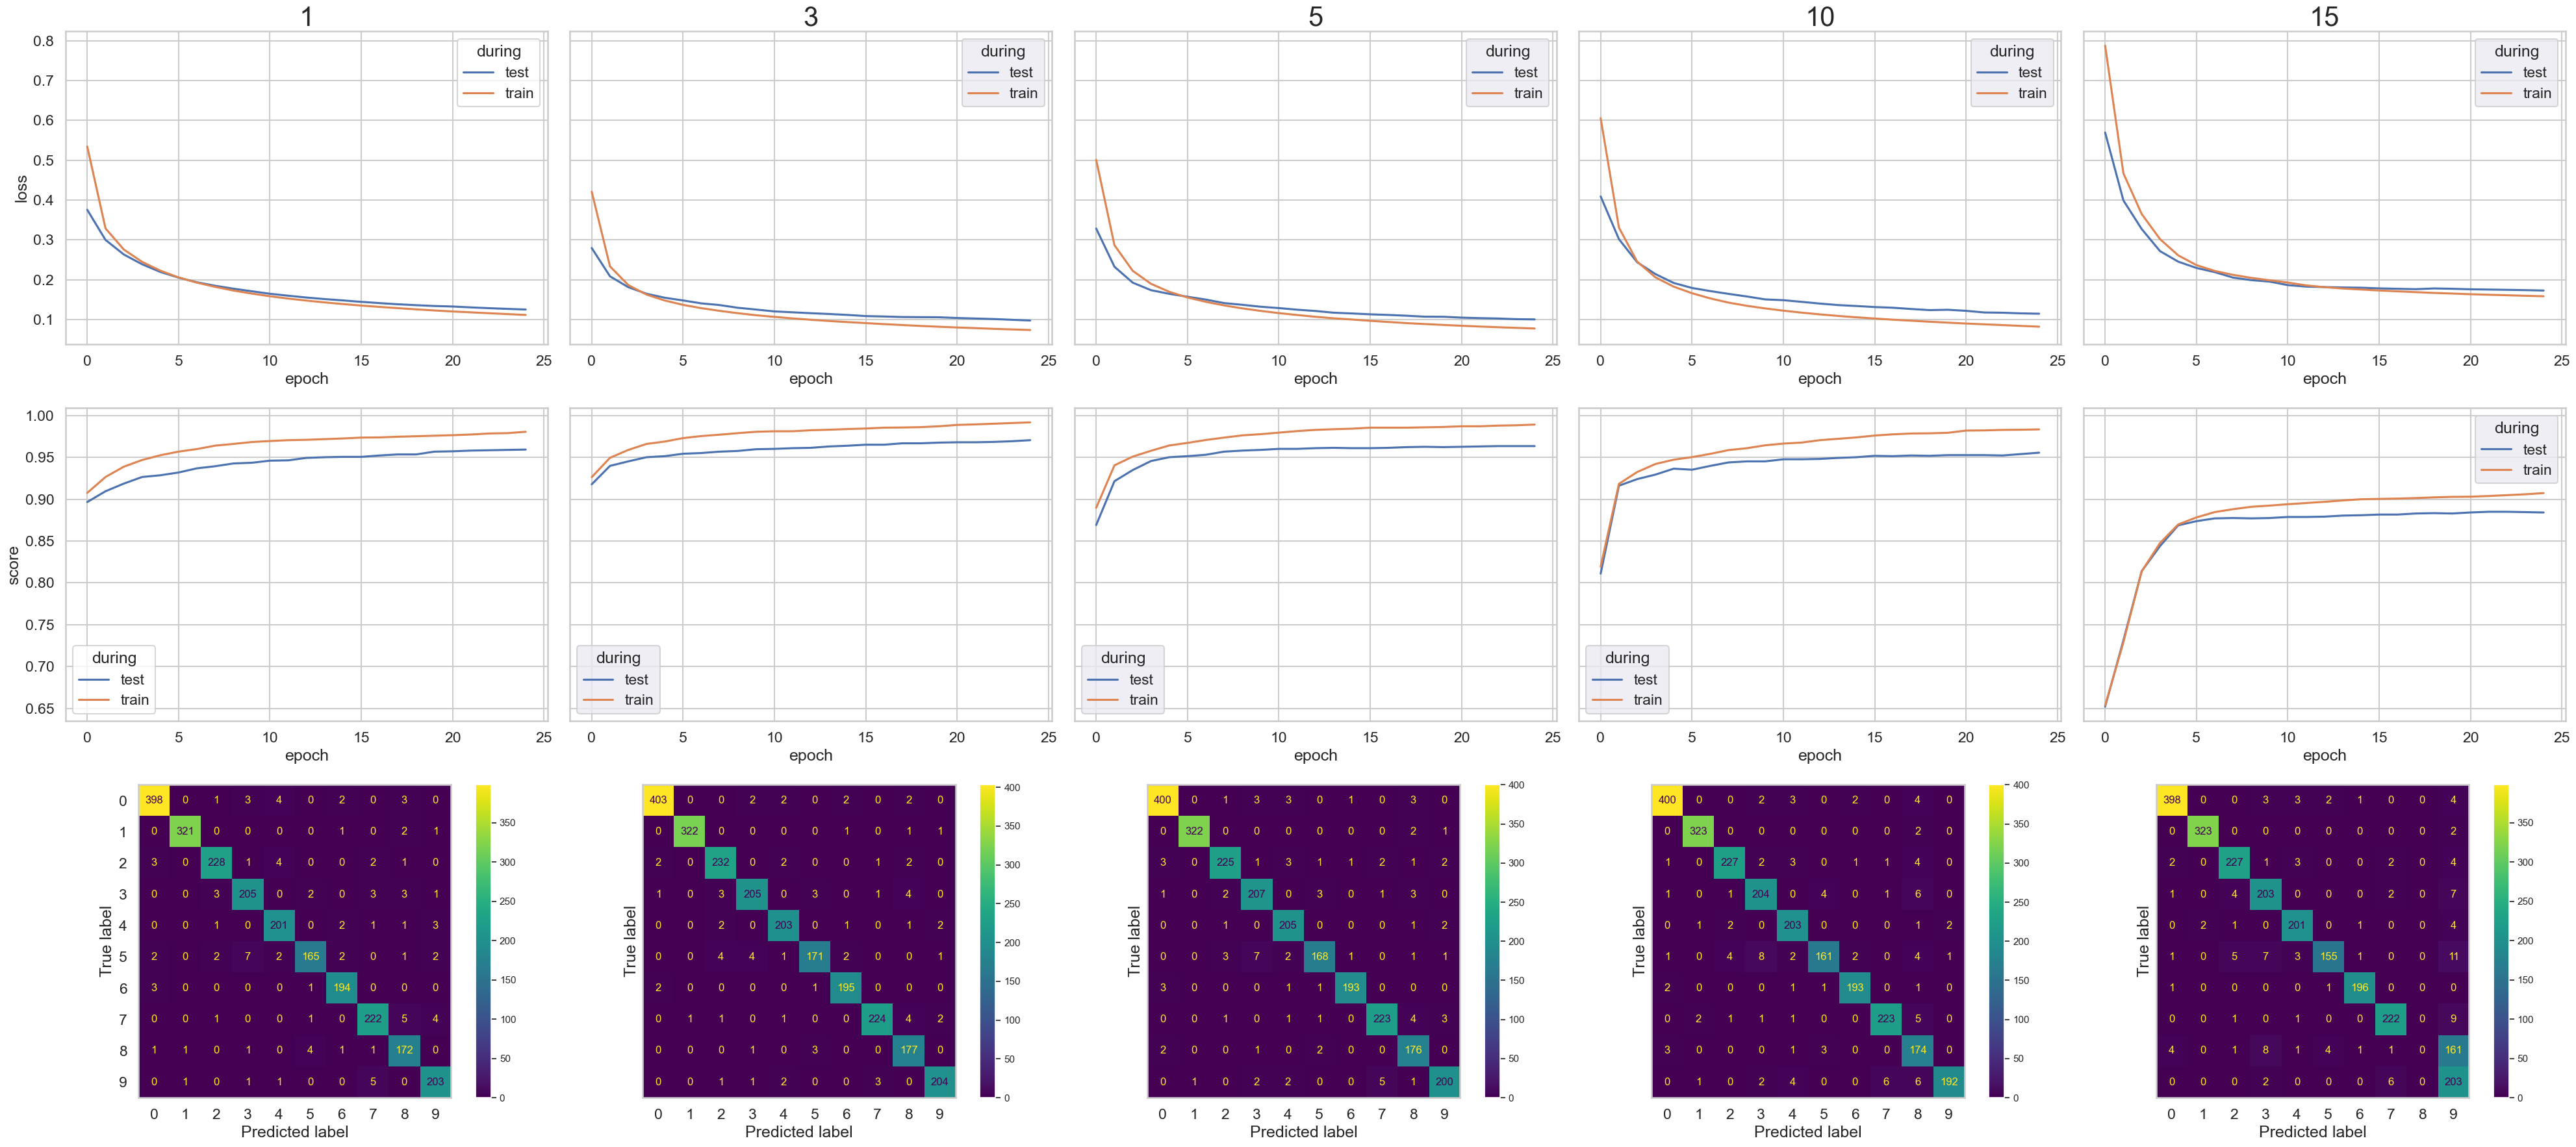

In [7]:
sns.set_theme(context= "talk", style='whitegrid', palette="deep")

fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(40, 18), sharey="row", sharex="row")
fig.set_tight_layout(True)

for i, k_size in enumerate([1, 3, 5, 10, 15]):
    ax_col = ax[:, i]
    ax_col[0].set_title(k_size, size=30)

    input_size = ((256 - k_size + 1) - 2) // 2 + 1

    net = Sequential(
        Conv1D(k_size, 1, 32, 1),
        MaxPool1D(2, 2),
        Flatten(),
        Linear(input_size * 32, 100),
        ReLU(),
        Linear(100, 10),
    )

    optimizer = Optim(net.reset(), CrossEntropyLoss(), eps=0.001)
    result_df = optimizer.SGD_eval(X_train[:, :, np.newaxis], y_train, 32, 25, test_size=0.33, return_dataframe=True)

    loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
    sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax_col[0])

    score_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['score_test', 'score_train'], value_name='score', var_name='during').replace({'score_test': 'test', 'score_train': 'train'})
    sns.lineplot(score_long_df, x='epoch', y='score', hue='during', ax=ax_col[1])
    
    sns.set_theme(context="notebook")
    ConfusionMatrixDisplay.from_predictions(optimizer.y_test.argmax(1), optimizer.network.forward(optimizer.X_test).argmax(1), ax=ax_col[2])
    ax_col[2].grid(False)
    sns.set_theme(context= "talk")
    
# fig.savefig("./reports/src/conv/conv_ksize.pdf", dpi=100, bbox_inches="tight")

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

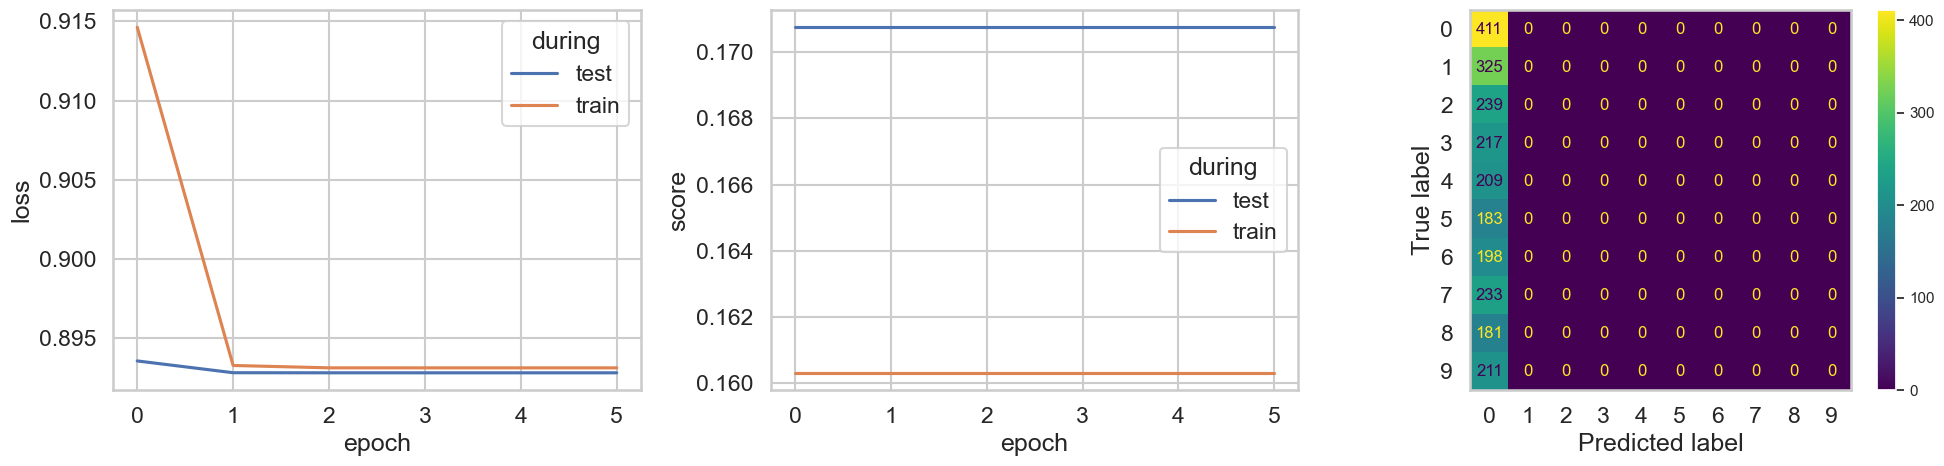

In [7]:
net = Sequential(
    Conv1D(3, 1, 32, 1, init_type="zeros"),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(4064, 100, init_type="zeros"),
    ReLU(),
    Linear(100, 10, init_type="zeros"),
)
optimizer = Optim(net, CrossEntropyLoss(), eps=0.001)
result_df = optimizer.SGD_eval(X_train[:,:,np.newaxis], y_train, 32, 25, test_size=0.33, return_dataframe=True)

plot("./reports/src/conv/conv_32batch_zeros.pdf")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/152 [00:00<?, ?it/s]

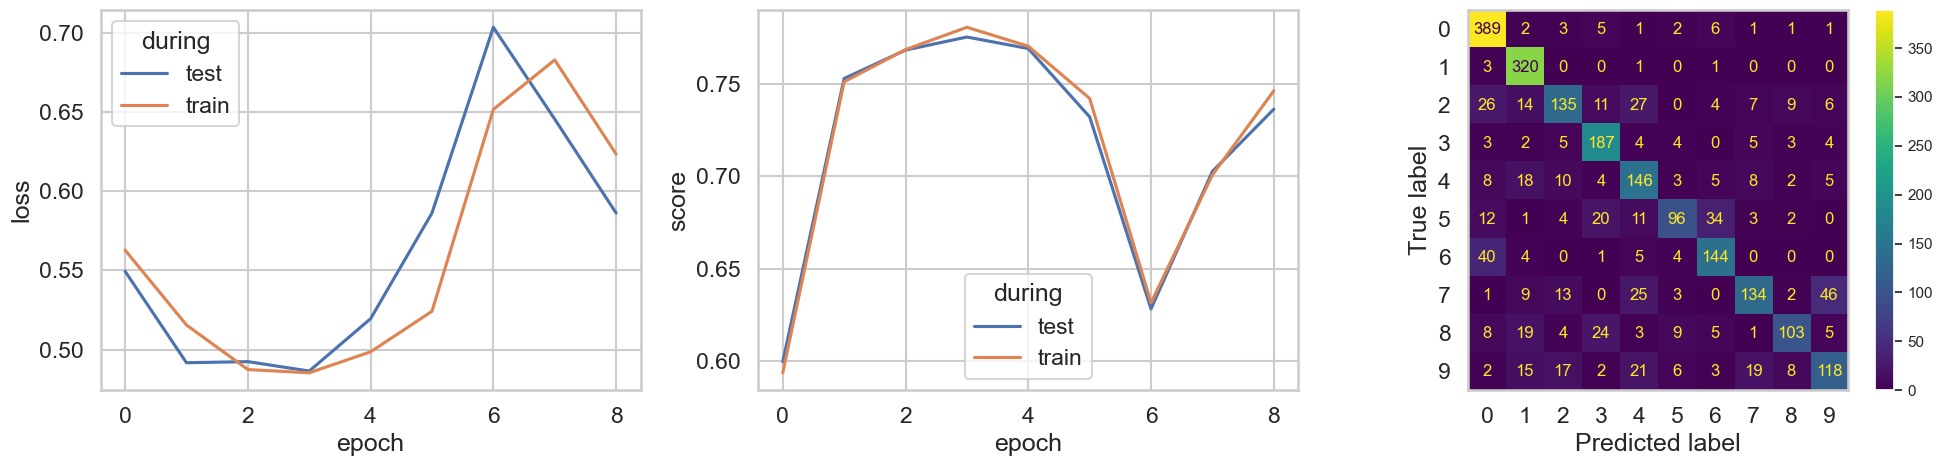

In [8]:
net = Sequential(
    Conv1D(3, 1, 32, 1),
    ReLU(),
    MaxPool1D(2, 2),
    Conv1D(3, 32, 32),
    ReLU(),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(1984, 10),
)
optimizer = Optim(net, CrossEntropyLoss(), eps=0.001)
result_df = optimizer.SGD_eval(X_train[:,:,np.newaxis], y_train, 32, 10, test_size=0.33, return_dataframe=True)

plot("./reports/src/conv/conv_2layers.pdf")


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/364 [00:00<?, ?it/s]

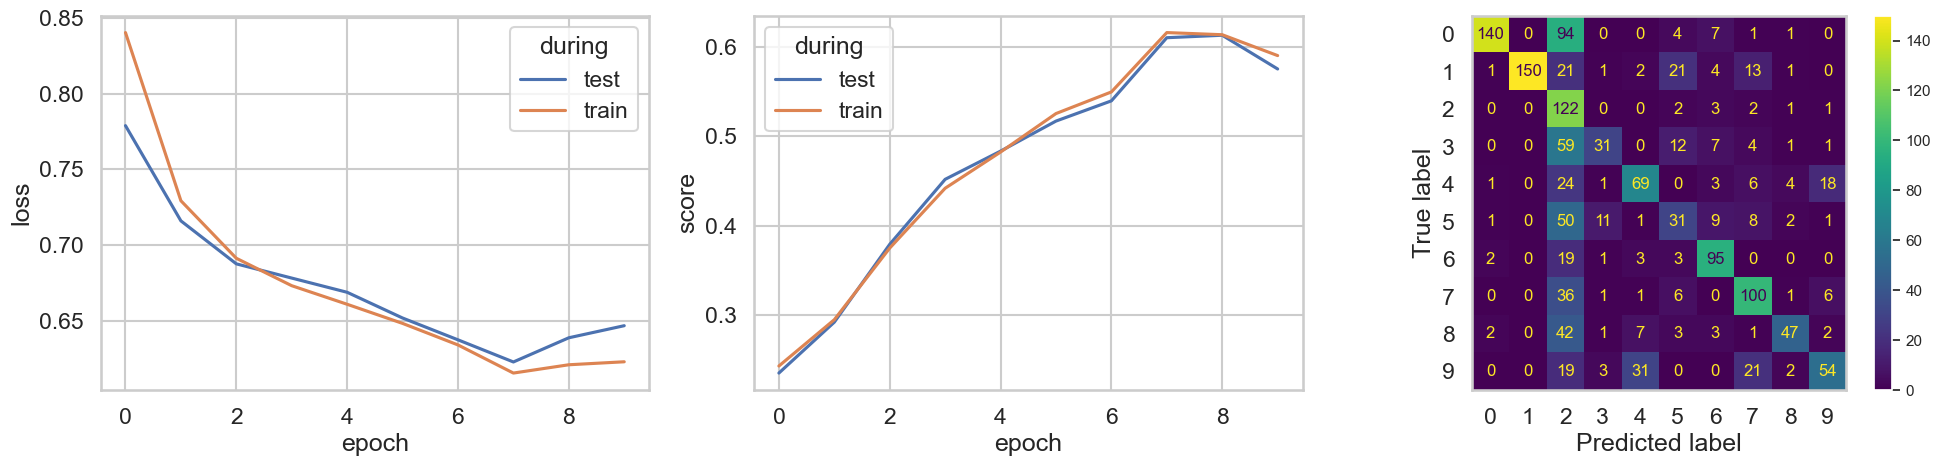

In [15]:
net = Sequential(
    Conv1D(3, 1, 64, 1, init_type="xavier_normal"),
    ReLU(),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    ReLU(),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    ReLU(),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    ReLU(),
    MaxPool1D(8, 2),
    Flatten(),
    Linear(512, 10)
)
optimizer = Optim(net, CrossEntropyLoss(), eps=0.001)
result_df = optimizer.SGD_eval(X_train[:,:,np.newaxis], y_train, 16, 10, test_size=0.2, return_dataframe=True)

plot("./reports/src/conv/conv_4layers.pdf")

In [ ]:
net = Sequential(
    Conv1D(3, 1, 64, 1, init_type="xavier_normal"),
    ReLU(),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    ReLU(),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    ReLU(),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    ReLU(),
    MaxPool1D(8, 2),
    Flatten(),
    Linear(512, 256, init_type="xavier_normal"),
    Sigmoid(),
    Linear(256, 10, init_type="xavier_normal")
)
optimizer = Optim(net, CrossEntropyLoss(), eps=0.001)
result_df = optimizer.SGD_eval(X_train[:,:,np.newaxis], y_train, 256, 10, test_size=0.2, return_dataframe=True)

plot("./reports/src/conv/conv_4layers_2linear.pdf")

100%|██████████| 10/10 [16:01<00:00, 96.19s/it]


,epoch,loss_test,loss_train,score_train,score_test
0,0,0.769695,0.709095,0.294582,0.309801
1,1,0.752502,0.803353,0.280521,0.289925
2,2,0.787683,0.830319,0.297154,0.297464
3,3,0.817779,0.841485,0.251029,0.250171
4,4,0.841477,0.852569,0.188443,0.191227
5,5,0.856036,0.877574,0.219136,0.222070
6,6,0.861767,0.865203,0.218621,0.228924
7,7,0.870662,0.867484,0.183642,0.160384
8,8,0.870994,0.871871,0.244684,0.256340
9,9,0.872767,0.877386,0.195816,0.183002


In [ ]:
net = Sequential(
    Conv1D(3, 1, 64, 1, init_type="xavier_normal"),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    MaxPool1D(8, 2),
    Conv1D(3, 64, 64, init_type="xavier_normal"),
    MaxPool1D(8, 2),
    Flatten(),
    Linear(512, 256, init_type="xavier_normal"),
    ReLU(),
    Linear(256, 10, init_type="xavier_normal")
)
optimizer = Optim(net, CrossEntropyLoss(), eps=0.001)
result_df = optimizer.SGD_eval(X_train[:,:,np.newaxis], y_train, 256, 10, test_size=0.2, return_dataframe=True)

plot("./reports/src/conv/conv_4layers_2linear_v2.pdf")

## Dirty documents

In [2]:
import os
import pandas as pd
from skimage import io, transform
from PIL import Image


def load_data(root_dir):
    size = (540, 420)
    X = []
    for filepath in os.listdir(root_dir + "/X"):
        imgpath = os.path.join(root_dir, "X", filepath)
        image = io.imread(imgpath)
        image = transform.resize(image, size)
        X.append(image)
    X = np.array(X)

    y = []
    for filepath in os.listdir(root_dir + "/y"):
        imgpath = os.path.join(root_dir, "y", filepath)
        image = io.imread(imgpath)
        image = transform.resize(image, size)
        y.append(image)
    y = np.array(y)

    return X, y


X, y = load_data("./data/dirty_documents")


In [3]:
X[:, np.newaxis, :, :].shape


(144, 1, 540, 420)

In [4]:
X[:, :, :, np.newaxis].shape


(144, 540, 420, 1)